<a target="_blank" href="https://colab.research.google.com/github/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/image-understanding-lda.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

If you have any problems opening it in colab, check the footer of this notebook.

# ISPR - Midterm 2 - Assignment 2: Image understanding via LDA

*Author: Leonardo Crociani - Student ID: 615392*

I have aimed to make the code as self-explanatory as possible. The notebook includes both code and markdown explanations where necessary. I hope the work meets the requirements! 🙂

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm.notebook import tqdm
import numpy as np
np.random.seed(0)

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

DATA_FOLDER = 'DSET1'

## Data preparation

The assignment requires reserving one image per subset for testing. Here, I exclude the last image of each subset for simplicity.

In [ ]:
filenames = sorted([ i for i in os.listdir(DATA_FOLDER) if i.endswith('.bmp') and not 'GT' in i ])
tr_filenames = []
ts_filenames = []

last_subset = None
for fname in filenames:
    subset, idx, _ = fname.split('_')
    if subset != last_subset and idx == '30':
        ts_filenames.append(fname)
        last_subset = subset
    else:
        tr_filenames.append(fname)

In [3]:
len(tr_filenames), len(ts_filenames)

(232, 8)

In [ ]:
def extract_keypoints_descriptors(img_path, strategy='sift', visualize=False):
    image_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()

    if strategy == 'sift':
        keypoints = sift.detect(image_gray, None)

    elif strategy == 'harris':
        harris = cv2.cornerHarris(np.float32(image_gray), 2, 3, 0.04)
        harris = cv2.dilate(harris, None)
        thresh = 0.01 * harris.max()
        keypoints = np.argwhere(harris > thresh)
        keypoints = [cv2.KeyPoint(float(pt[1]), float(pt[0]), 3) for pt in keypoints]

    elif strategy == 'fast':
        fast = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
        keypoints = fast.detect(image_gray, None)

    elif strategy == 'agast':
        agast = cv2.AgastFeatureDetector_create()
        keypoints = agast.detect(image_gray, None)

    keypoints, descriptors = sift.compute(image_gray, keypoints) # the descriptors are computed with SIFT, independent of the keypoint strategy

    if visualize:
        print(f'Found {len(keypoints)} keypoints using {strategy}')
        image_color = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image_with_keypoints = cv2.drawKeypoints(
            image_color, keypoints, None,
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
            color=(0, 255, 0)
        )
        plt.imshow(image_with_keypoints[..., ::-1]) 
        plt.title(f'Keypoints - {strategy}')
        plt.axis('off')
        plt.show()

    return keypoints, descriptors


Let's test the strategies, to see which one performs better.

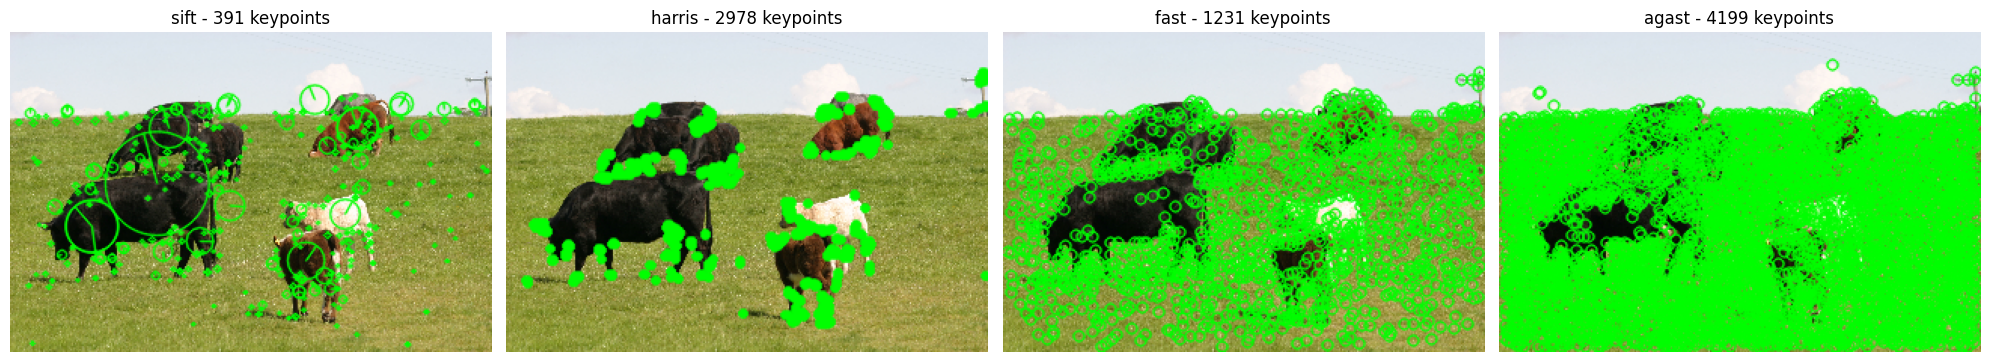

In [ ]:
strategies = ['sift', 'harris', 'fast', 'agast']
img_path = f'{DATA_FOLDER}/{tr_filenames[1]}'
plt.figure(figsize=(20, 12))

for i, strat in enumerate(strategies):
    plt.subplot(1, 4, i + 1)
    keypoints, _ = extract_keypoints_descriptors(img_path, strategy=strat, visualize=False)

    image_color = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image_with_keypoints = cv2.drawKeypoints(
        image_color, keypoints, None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
        color=(0, 255, 0)
    )
    plt.imshow(image_with_keypoints[..., ::-1]) 
    plt.title(f'{strat} - {len(keypoints)} keypoints')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

SIFT seems to be the best approach for finding keypoints, focusing (mostly) on relevant content of the image, and returning less number of keypoints with respect to the others. Thus, I decided to use SIFT both for keypoint detection and descriptor extraction.

In [6]:
STRATEGY = 'sift'

In [7]:
def get_keypoints_and_descriptors(filenames_set):
    DICT = { 'keypoints' : [], 'descriptors' : [] }
    for img in tqdm(filenames_set, desc='Extracting keypoints and descriptors'):
        keypoints, descriptors = extract_keypoints_descriptors(f'{DATA_FOLDER}/{img}', STRATEGY)
        DICT['descriptors'].append(descriptors)
        DICT['keypoints'].append(keypoints)
    return DICT

TR = get_keypoints_and_descriptors(tr_filenames)

Extracting keypoints and descriptors:   0%|          | 0/232 [00:00<?, ?it/s]

## Parameter Search for KMeans and LDA
To find optimal values for `K` (vocabulary size) and `num_topics`, I perform a grid search over:
- `K ∈ {200, 400, 600, 800}`
- `num_topics ∈ {8, 12, 16, 20}`  

I evaluate each combination with the coherence score ([Gensim CoherenceModel](https://radimrehurek.com/gensim/models/coherencemodel.html)), which measures semantic similarity of top words in each topic.

In [9]:
def build_bovw_histograms(descriptor_sets, kmeans_model):
    k = kmeans_model.n_clusters
    histograms = []
    for descriptors in tqdm(descriptor_sets, desc="Building BoVW histograms"):
        if descriptors is None or len(descriptors) == 0:
            hist = np.zeros(k)
        else:
            words = kmeans_model.predict(descriptors)
            hist, _ = np.histogram(words, bins=np.arange(k+1))
        histograms.append(hist)
    return np.array(histograms)

def plot_bovw_histogram(hist, title):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(hist)), hist)
    plt.title(title)
    plt.xlabel('Visual Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()
    

In [10]:
all_descriptors = np.vstack([desc for desc in TR['descriptors'] if desc is not None]) # merging the descriptors in a single array

In [11]:
all_descriptors.shape

(106904, 128)

Processing K values:   0%|          | 0/4 [00:00<?, ?it/s]

Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

K=200, num_topics=8, Coherence=0.2851


Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

K=200, num_topics=12, Coherence=0.2917


Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

K=200, num_topics=16, Coherence=0.2887


Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

K=200, num_topics=20, Coherence=0.2814


Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

K=400, num_topics=8, Coherence=0.3031


Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

K=400, num_topics=12, Coherence=0.3113


Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

K=400, num_topics=16, Coherence=0.2659


Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

K=400, num_topics=20, Coherence=0.2786


Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

K=600, num_topics=8, Coherence=0.3252


Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

K=600, num_topics=12, Coherence=0.3253


Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

K=600, num_topics=16, Coherence=0.3219


Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

K=600, num_topics=20, Coherence=0.3221


Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

K=800, num_topics=8, Coherence=0.2812


Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

K=800, num_topics=12, Coherence=0.2742


Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

K=800, num_topics=16, Coherence=0.2918


Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

K=800, num_topics=20, Coherence=0.2979


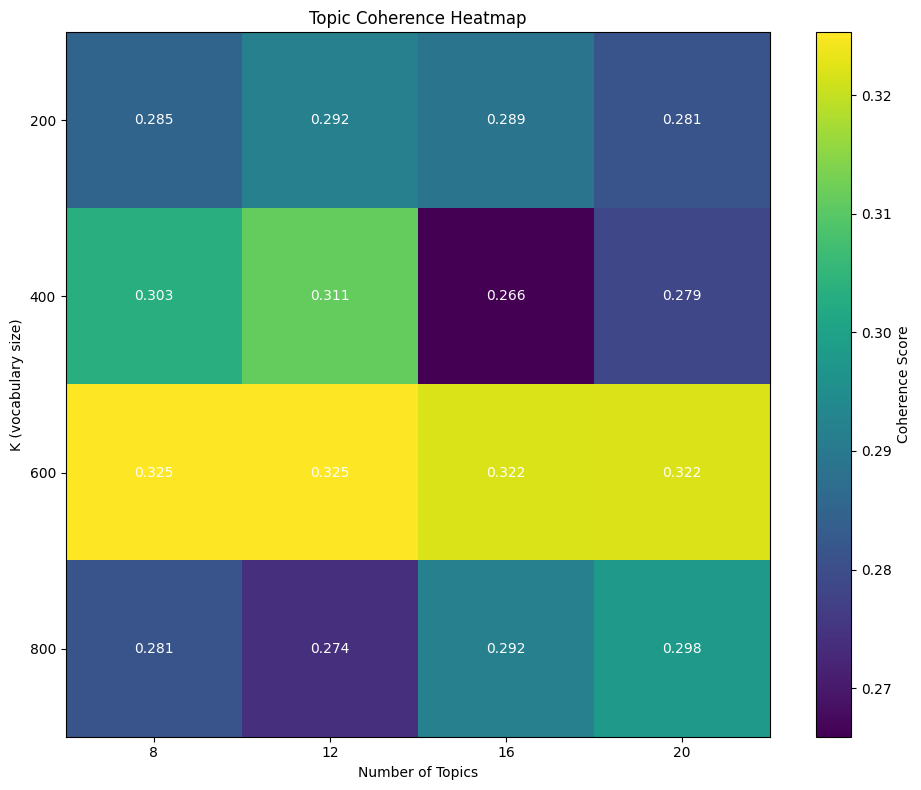

Best parameters: K=600, num_topics=12, Coherence=0.3253


In [12]:
Ks = [200, 400, 600, 800]
Ns = [8, 12, 16, 20]

def evaluate_model(k, num_topics, all_descriptors, TR_descriptors):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(all_descriptors)

    histograms = build_bovw_histograms(TR_descriptors, kmeans)
    
    texts = [
        [str(word_id) for word_id, freq in enumerate(hist) for _ in range(int(freq))]
        for hist in histograms
    ]

    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]

    model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        random_state=0,
    )

    cm = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence = cm.get_coherence()

    return k, num_topics, coherence, model, kmeans, id2word, corpus

results = []
for k in tqdm(Ks, desc="Processing K values"):
    for num_topics in Ns:
        result = evaluate_model(k, num_topics, all_descriptors, TR['descriptors'])
        results.append(result)
        print(f"K={k}, num_topics={num_topics}, Coherence={result[2]:.4f}")

k_values = [k for k, _, _, _, _, _, _ in results]
topic_values = [t for _, t, _, _, _, _, _ in results]
coherences = [coh for _, _, coh, _, _, _, _ in results]

best_coherence = -1
best_k = None
best_num_topics = None
best_model = None
best_kmeans = None

for k, num_topics, coherence, model, kmeans, _, _ in results:
    if coherence > best_coherence:
        best_coherence = coherence
        best_k = k
        best_num_topics = num_topics
        best_model = model
        best_kmeans = kmeans

coherence_matrix = np.zeros((len(Ks), len(Ns)))
for i, k in enumerate(Ks):
    for j, num_topics in enumerate(Ns):
        for res_k, res_topics, res_coherence, _, _, _, _ in results:
            if res_k == k and res_topics == num_topics:
                coherence_matrix[i, j] = res_coherence
                break

plt.figure(figsize=(10, 8))
plt.imshow(coherence_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Coherence Score')
plt.xticks(np.arange(len(Ns)), Ns)
plt.yticks(np.arange(len(Ks)), Ks)
plt.xlabel('Number of Topics')
plt.ylabel('K (vocabulary size)')
plt.title('Topic Coherence Heatmap')

for i in range(len(Ks)):
    for j in range(len(Ns)):
        plt.text(j, i, f"{coherence_matrix[i, j]:.3f}", 
                 ha="center", va="center", color="white" if coherence_matrix[i, j] < 0.5 else "black")

plt.tight_layout()
plt.show()

print(f"Best parameters: K={best_k}, num_topics={best_num_topics}, Coherence={best_coherence:.4f}")

_For curiosity_, below is the BoVW histogram for the first training image.

Building BoVW histograms:   0%|          | 0/232 [00:00<?, ?it/s]

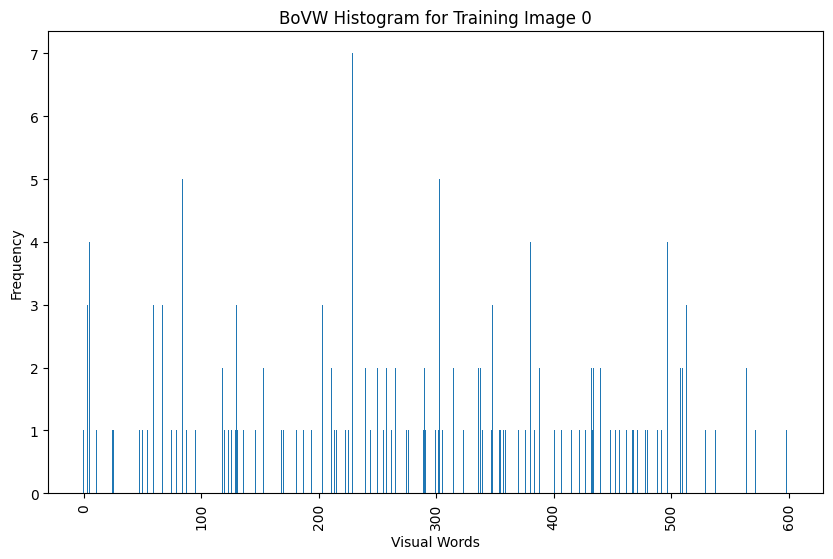

In [13]:
train_bovw = build_bovw_histograms(TR['descriptors'], best_kmeans)
plot_bovw_histogram(train_bovw[0], 'BoVW Histogram for Training Image 0')

The visual words are nicely distributed, with some peaks, which is nice. These peaks are the words that are more frequent in the image!

## Testing on the Held‑Out Set
We now apply the trained BoVW + LDA pipeline to the test images and visualize topic assignments on strong keypoints.

In [14]:
TS = get_keypoints_and_descriptors(ts_filenames)
test_bovw = build_bovw_histograms(TS['descriptors'], best_kmeans)

Extracting keypoints and descriptors:   0%|          | 0/8 [00:00<?, ?it/s]

Building BoVW histograms:   0%|          | 0/8 [00:00<?, ?it/s]

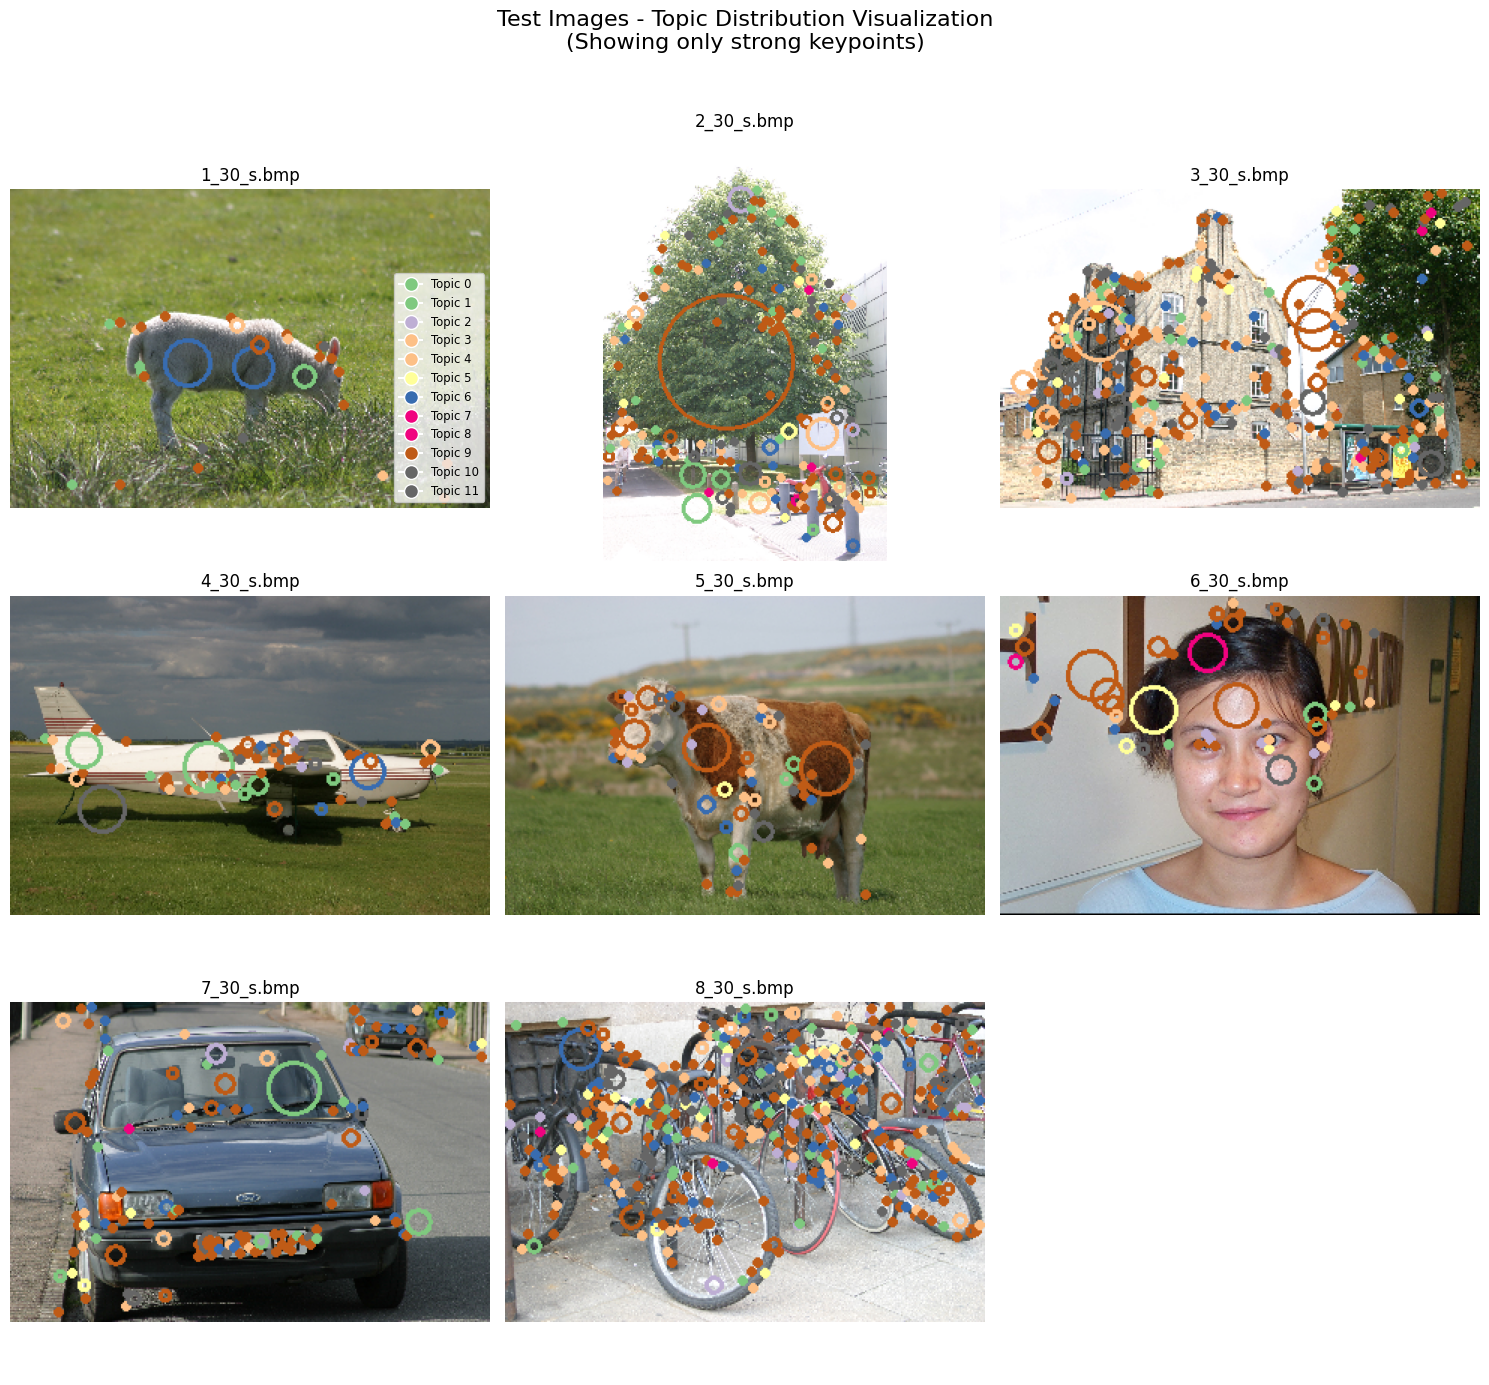

In [ ]:
topic_colors = cm.get_cmap('Accent', best_num_topics) # colormap from matplotlib
lambda_tw = best_model.state.get_lambda() # lambda matrix of the LDA model => topics x words

def topic_of_word(word_id):
    return int(np.argmax(lambda_tw[:, word_id]))

def visualize_test_image_gensim(ax, img_name, keypoints, descriptors, min_response=0.03): # min_response is a threshold for plotting only "strong" keypoints
    words = best_kmeans.predict(descriptors)
    topics = [topic_of_word(w) for w in words]
    
    img = cv2.imread(f'{DATA_FOLDER}/{img_name}')
    img_out = img.copy()
    
    topic_counts = {}
    for t in topics:
        if t in topic_counts:
            topic_counts[t] += 1
        else:
            topic_counts[t] = 1
    
    strong_kps = []
    strong_topics = []
    
    for kp, top in zip(keypoints, topics):
        if kp.response > min_response:
            strong_kps.append(kp)
            strong_topics.append(top)
    
    for kp, top in zip(strong_kps, strong_topics):
        x, y = int(kp.pt[0]), int(kp.pt[1])
        rgba_color = topic_colors(top)
        rgb_color = rgba_color[:3]
        bgr_color = (int(rgb_color[2]*255), int(rgb_color[1]*255), int(rgb_color[0]*255))
        radius = max(2, int(kp.size // 2))
        cv2.circle(img_out, (x, y), radius, bgr_color, thickness=2)
    
    ax.imshow(img_out[..., ::-1])
    
    title = f"{img_name}"
        
    ax.set_title(title)
    ax.axis('off')
    
    # show legend only for the first image
    if img_name == ts_filenames[0]:
        legend_elements = []
        for i in range(best_num_topics):
            rgba = topic_colors(i)
            legend_elements.append(
                plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=rgba, markersize=10, label=f'Topic {i}')
            )
        ax.legend(handles=legend_elements, loc='lower right', fontsize='small')
    

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

topic_to_images = {}

for idx, img_name in enumerate(ts_filenames):
    kps, desc = TS['keypoints'][idx], TS['descriptors'][idx]
    visualize_test_image_gensim(axes[idx], img_name, kps, desc)

for i in range(len(ts_filenames), len(axes)):
    axes[i].axis('off')

plt.suptitle("Test Images - Topic Distribution Visualization\n(Showing only strong keypoints)", fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

## Conclusions

For each image in the test set, we observe that - despite the inherent noise - the model is sometimes able to assign the same topic to visually similar points of interest. Take, for instance, the image of the young lady: both eyes are assigned to the same topic (light purple). Similarly, the cow’s visually similar regions are mapped to the same topic (brownish red), and the same holds true for comparable regions on the lamb.

Interestingly, we also see some topic consistency across images: regions with a uniform color distribution and subtle light‑and‑shadow variations such as the main keypoints on the cow’s body are assigned the same topic as the main area of the tree, showing that the model captures shared texture and color patterns across contexts; a similar consistency appears on the lady’s forehead.

I hope you enjoyed the notebook! 😊

### References:

- Chatty demo on bow representation in python: [https://kushalvyas.github.io/BOV.html](https://kushalvyas.github.io/BOV.html)

- Wikipedia page on LDA: [https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)

- Our lectures :)

### Links:

- Link to open the github repo: [https://github.com/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/image-understanding-lda.ipynb](https://github.com/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/image-understanding-lda.ipynb)

- Link to open it in colab: [https://colab.research.google.com/github/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/image-understanding-lda.ipynb](https://colab.research.google.com/github/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/image-understanding-lda.ipynb)